# Intel Cervical Cancer Screening
### April 21, 2017
## Satchel Grant

### Overview
The goal of this notebook is to classify a woman's cervical type into 1 of 3 classes from medical imaging data. This assists in determination of cancer diagnoses and treatments.

### Initial Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.utils import shuffle
import scipy.misc as sci
import time
from PIL import Image
import random
import scipy.ndimage.interpolation as scizoom

%matplotlib inline

def show(img):
    plt.imshow(img)
    plt.show()

### Reading in the Data
The images are stored as jpg files, stored in folders corresponding to their classification. I read in the image os paths to be converted to images later in batches. I store their classification in a parallel array. 

In [2]:
root_path = './train/'

def read_paths(path, no_labels=False):
    # ** Takes a root path and returns all of the file 
    # paths within the root directory. It uses the 
    # subdirectories to create a corresponding label array **

    # path - the path to the root directory
    # no_labels - optional argument to use file 
    #             names as labels instead of subdirectory
    
    file_paths = []
    labels = []
    labels_to_nums = dict()
    for dir_name, subdir_list, file_list in os.walk(path):
        if len(subdir_list) > 0:
            n_labels = len(subdir_list)
            for i,subdir in enumerate(subdir_list):
                labels_to_nums[subdir] = i
        else:
            type_ = dir_name.split('/')[-1]
        for img_file in file_list:
            if '.jpg' in img_file.lower():
                file_paths.append(os.path.join(dir_name,img_file))
                if no_labels: labels.append(img_file)
                else: labels.append(labels_to_nums[type_])
    return file_paths, labels, n_labels
    

image_paths, labels, n_labels = read_paths(root_path)
image_paths, labels = shuffle(image_paths, labels)

print("Number of data samples: " + str(len(image_paths)))
print("Number of Classes: " + str(n_labels))

Number of data samples: 1481
Number of Classes: 3


This is a relatively small number of samples to use for deep learning... Luckily Kaggle provided more samples than just those in the train set. I will read those in as well after initial prototyping is finished.

### Data Augmentation
The following cells add rotations and translations to the dataset. This increases the number of samples for training which helps the model generalize better. This prevents overfitting the training set.

In [3]:
def rotate(image, angle, ones=None, color_range=255):
    # ** Rotates an image by the specified angle amount
    # and fills in resulting space with random values **
    
    # image - the image as numpy array to be rotated
    # angle - the desired amount of rotation in degrees
    # ones - an numpy array of ones like the image with the same rotation
    #        (used for broadcasting random filling into black space from rotation)
    # color_range - the range of color values for the random filling
    
    if ones == None:
        ones = sci.imrotate(np.ones_like(image),angle)
    rot_image = sci.imrotate(image, angle).astype(np.float32)
    edge_filler = np.random.random(rot_image.shape).astype(np.float32)*color_range
    rot_image[ones[:,:,:]!=1] = edge_filler[ones[:,:,:]!=1]
    return rot_image

def translate(img, row_amt, col_amt, color_range=255):
    # ** Returns a translated copy of an image by the specified row and column amount
    # and fills in the empty space with random values **
    
    # image - the source image as numpy array to be translated
    # row_shift - the maximum vertical translation in both directions in pixels
    # col_shift - the maximum horizontal translation in both directions in pixels
    # color_range - the range of color values for the random filling
    translation = np.random.random(img.shape).astype(img.dtype)*color_range
    if row_amt > 0:
        if col_amt > 0:
            translation[row_amt:,col_amt:] = img[:-row_amt,:-col_amt]
        elif col_amt < 0:
            translation[row_amt:,:col_amt] = img[:-row_amt,-col_amt:]
        else:
            translation[row_amt:,:] = img[:-row_amt,:]
    elif row_amt < 0:
        if col_amt > 0:
            translation[:row_amt,col_amt:] = img[-row_amt:,:-col_amt]
        elif col_amt < 0:
            translation[:row_amt,:col_amt] = img[-row_amt:,-col_amt:]
        else:
            translation[:row_amt,:] = img[-row_amt:,:]
    else:
        if col_amt > 0:
            translation[:,col_amt:] = img[:,:-col_amt]
        elif col_amt < 0:
            translation[:,:col_amt] = img[:,-col_amt:]
        else:
            return img.copy()
    return translation

def random_zoom(image, max_zoom=1/3.):
    # ** Returns a randomly zoomed (scaled) copy of an image within the scaling amount.
    # if the scaling zooms outward, the empty space is filled with random values **
    
    # image - the source image as numpy array to be scaled
    # max_zoom - the maximum scaling amount in either direction
    
    color_range = 255
    zoom_factor = 1 + (random.random()-0.5)*max_zoom
    while zoom_factor == 1:
        zoom_factor = 1 + (random.random()-0.5)*max_zoom
    # scipy's zoom function returns different size array
    # The following code ensures the zoomed image has same pixel size as initial image
    img_height, img_width = image.shape[:2]
    zoomed_h = round(img_height*zoom_factor)
    zoomed_w = round(img_width*zoom_factor)
    diff_h = abs(zoomed_h-img_height)
    diff_w = abs(zoomed_w-img_width)
    start_row = round(diff_h/2)
    start_col = round(diff_w/2)
    
    # Zoom in on image
    if zoom_factor > 1:
        end_row = start_row+img_height
        end_col = start_col+img_width
        zoom_img = scizoom.zoom(image,(zoom_factor,zoom_factor,1),output=np.uint8)[start_row:end_row,
                                                               start_col:end_col]
    # Zoom out on image
    elif zoom_factor < 1:
        temp = scizoom.zoom(image,(zoom_factor,zoom_factor,1),output=np.uint8)
        temp_height, temp_width = temp.shape[:2]
        zoom_img = np.random.random(image.shape)*color_range # Random pixels instead of black space for out zoom
        zoom_img[start_row:start_row+temp_height,
                 start_col:start_col+temp_width] = temp[:,:]
    else:
        return image.copy()
    return zoom_img.astype(np.float32)

def random_augment(image, rotation_limit=10, shift_limit=10, zoom_limit=1/3.):
    # ** Returns randomly rotated, translated, and scaled copy of an image. **
    
    # image - source image as numpy array to be randomly augmented
    # rotation_limit - maximum rotation degree in either direction
    # shift_limit - maximum translation amount in either direction
    # zoom_limit - maximum scaling amount in either direction
    
    # Rotation
    random_angle = random.randint(-10,10)
    ones = sci.imrotate(np.ones_like(image),random_angle)
    aug_image = rotate(image,random_angle,ones)
    
    # Translation
    row_shift = random.randint(-shift_limit, shift_limit)
    col_shift = random.randint(-shift_limit, shift_limit)
    aug_image = translate(aug_image,row_shift,col_shift)
    
    # Scale
    aug_image = random_zoom(aug_image,max_zoom=zoom_limit)
    
    return aug_image

def one_hot_encode(labels, n_classes):
    # ** Takes labels as values and converts them into one_hot labels. 
    # Returns numpy array of one_hot encodings **
    
    # labels - array or numpy array of single valued labels
    # n_classes - number of potential classes in labels
    one_hots = []
    for label in labels:
        one_hot = [0]*n_classes
        if label >= len(one_hot):
            print("Labels out of bounds\nCheck your n_classes parameter")
            return
        one_hot[label] = 1
        one_hots.append(one_hot)
    return np.array(one_hots,dtype=np.float32)


### Split into Training and Validation Sets
It is important to set aside images for validation. This is how you can determine if your model is overfitting or underfitting during training.


In [ ]:
training_percentage = .75
total_samples = len(image_paths)
split_index = int(training_percentage*total_samples)

X_train_paths, y_train = image_paths[:split_index], labels[:split_index]
X_valid_paths, y_valid = image_paths[split_index:], labels[split_index:]

In [ ]:
print("Number of Training Samples: " + str(len(y_train)))
print("Number of Validation Samples: " + str(len(y_valid)))

Since I am completing this notebook over the course of multiple days, I save the training paths and validation paths into seperate csv files along with their classification. This is essentially a checkpoint step so that it is easy to repeatedly save and restore the weights of the model later in the process.

In [ ]:
def save_paths(file_name, paths, labels):
    with open(file_name, 'w') as csv_file:
        for path,label in zip(paths,labels):
            csv_file.write(path + ',' + str(label) + '\n')

save_paths('train_set.csv', X_train_paths, y_train)
save_paths('valid_set.csv', X_valid_paths, y_valid)

### Reading in Previously Split Data
Here I read in the training and validation image paths from the csv files. This ensures that the two sets remain seperate throughout the notebook.

In [4]:
def get_split_data(file_name):
    paths = []
    labels = []
    with open(file_name, 'r') as f:
        for line in f:
            split_line = line.strip().split(',')
            paths.append(split_line[0])
            labels.append(int(split_line[1]))
    return paths,labels
            

In [5]:
X_train_paths, y_train = get_split_data('train_set.csv')
X_valid_paths, y_valid = get_split_data('valid_set.csv')
n_labels = max(y_train)+1
print("Number of Training Samples: " + str(len(y_train)))
print("Number of Validation Samples: " + str(len(y_valid)))

Number of Training Samples: 1110
Number of Validation Samples: 371


### Generator and Image Reader
To maximize memory, the images for both testing and training can be read in in batches. This increases the amount of images that can be trained on in a single epoch which helps the model generalize. In most cases, more training data is better for deep learning. 

In [6]:
def convert_images(paths, labels, resize_dims=(256,256), randomly_augment=False):
    # ** Reads in images from their paths, resizes the images and returns 
    # the images with their corresponding labels. **
    
    # paths - the file paths to the images
    # labels - a numpy array of the corresponding labels to the images
    # resize_dims - the resizing dimensions for the image
    # add_zooms - optional parameter to add randomly scaled copies of the images to the output
    # randomly_augment - optional parameter to add randomly rotated, 
    #                    translated, and scaled images to the output
    
    images = []
    new_labels = []
    for path,label in zip(paths,labels):
        img = mpimg.imread(path)
        resized_img = sci.imresize(img, resize_dims)
        images.append(resized_img)
        if randomly_augment:
            images.append(random_augment(resized_img))
            new_labels.append(label)
            new_labels.append(label)
    if randomly_augment: 
        return np.array(images,dtype=np.float32), np.array(new_labels,dtype=np.float32)
    return np.array(images,dtype=np.float32), labels



def image_generator(file_paths, labels, batch_size, resize_dims=(256,256), randomly_augment=False):
    # ** Generator function to convert image file paths to images with labels in batches. **
    
    # file_paths - an array of the image file paths as strings
    # labels - a numpy array of labels for the corresponding images
    # batch_size - the desired size of the batch to be returned at each yield
    # resize_dims - the desired x and y dimensions of the images to be read in
    # add_zooms - optional parameter add an additional randomly zoomed image to the batch for each file path
    # randomly_augment - optional parameter add an additional randomly rotated, translated, 
    #         and zoomed image to the batch for each file path
    
    if randomly_augment: 
        batch_size = int(batch_size/2) # the other half of the batch is filled with augmentations
    while 1:
        file_paths,labels = shuffle(file_paths,labels)
        for batch in range(0, len(file_paths), batch_size):
            images, batch_labels = convert_images(file_paths[batch:batch+batch_size], 
                                                  labels[batch:batch+batch_size], 
                                                  resize_dims=resize_dims,
                                                  randomly_augment=randomly_augment)
            yield images, batch_labels



#### Note on Image Generation
The cervical images come in different sizes. Because I will be using transfer learning, the images need to be resized to 256x256 anyway. I will try this method and see what kind of results I get. 

If the results are too poor, I will try anti warping methods from the cv2 library such as cv2.calibrate and cv2.undistort. If I am still getting poor results, I will try using RNNs to find the key elements of the picture and crop the image. I may use this last technique regardless of my initial results simply to practice the method. It has proved very successful for other people on other projects in the past.

In [7]:
batch_size = 128
add_random_augmentations = True
resize_dims = (256,256)


n_train_samples = len(X_train_paths)
if add_random_augmentations: 
    n_train_samples = 2*len(X_train_paths)

train_steps_per_epoch = n_train_samples//batch_size + 1
if n_train_samples % batch_size == 0: train_steps_per_epoch = n_train_samples//batch_size

valid_steps_per_epoch = len(X_valid_paths)//batch_size


train_generator = image_generator(X_train_paths, 
                                  y_train, 
                                  batch_size,
                                  resize_dims=resize_dims,
                                  randomly_augment=add_random_augmentations)
valid_generator = image_generator(X_valid_paths, y_valid, 
                                  batch_size, resize_dims=resize_dims)

/Users/satchelgrant/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/satchelgrant/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


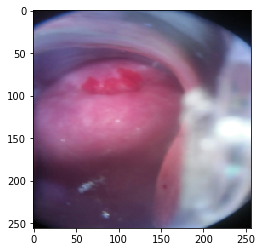

1.0


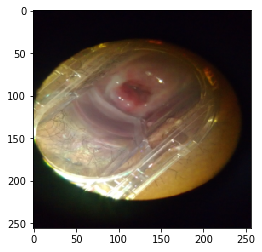

0.0


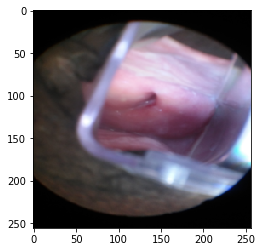

2.0


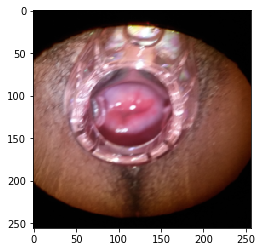

1.0


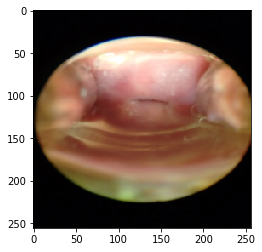

2.0


In [11]:
image_gen = image_generator(X_train_paths[:10], y_train[:10], 2,randomly_augment=True)

for i in range(5):
    imgs, labels = next(image_gen)
    imgs = imgs.astype(np.uint8)
    show(imgs[0])
    print(labels[0])

In [ ]:
plt.hist(np.array(y_train,dtype='float32'),3)
plt.show()

## Keras Section

### Keras Imports


In [9]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Dropout, concatenate
from keras.layers.normalization import BatchNormalization


### Keras Model
I'm going to try using a personal model that has given me good success in the past. If it seems to produce bad results, I will likely try to use transfer learning instead and use a model like the Inception net. Cervixes, however, only have so many features that are important to notice. And these features seem more esoteric than the imagenet features that most pretrained models are trained on. My personal model trains quicker and easier than the larger nets and uses newer methods like batchnormalization and parallel convolutions. Thus I'm going to try it first and reevaluate if results are poor.

In [11]:
stacks = []
conv_shapes = [(1,1),(3,3),(5,5)]
conv_depths = [8,10,10,10]
pooling_filter = (2,2)
pooling_stride = (2,2)
dense_shapes = [150,50,n_labels]

inputs = Input(shape=(resize_dims[0],resize_dims[1],3))
zen_layer = BatchNormalization()(inputs)

for shape in conv_shapes:
    stacks.append(Conv2D(conv_depths[0], shape, padding='same', activation='elu')(inputs))
layer = concatenate(stacks,axis=-1)
layer = BatchNormalization()(layer)
layer = MaxPooling2D(pooling_filter,strides=pooling_stride,padding='same')(layer)
layer = Dropout(0.05)(layer)

for i in range(1,len(conv_depths)):
    stacks = []
    for shape in conv_shapes:
        stacks.append(Conv2D(conv_depths[i],shape,padding='same',activation='elu')(layer))
    layer = concatenate(stacks,axis=-1)
    layer = BatchNormalization()(layer)
    layer = Dropout(i*10**-2+.05)(layer)
    layer = MaxPooling2D(pooling_filter,strides=pooling_stride, padding='same')(layer)

layer = Flatten()(layer)
layer = Dropout(0.55)(layer)

for i in range(len(dense_shapes)-1):
    layer = Dense(dense_shapes[i], activation='elu')(layer)
    if i == 0:
        layer = Dropout(0.5)(layer)
    layer = BatchNormalization()(layer)

outputs = Dense(dense_shapes[-1], activation='softmax')(layer)

### Keras Training
I read in a pretrained model that was trained on classifying statefarm drivers. Hopefully this will speed up the training process.

In [ ]:
model = Model(inputs=inputs,outputs=outputs)
model.load_weights('model.h5')
adam_opt = mode
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit_generator(train_generator, train_steps_per_epoch, epochs=1,
                    validation_data=valid_generator,validation_steps=valid_steps_per_epoch)
model.save('model.h5')
